In [1]:
import os
import pandas as pd
import numpy as np
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import quandl
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import statsmodels.stats as sms
import scipy.stats as scs
from arch import arch_model
from statsmodels.tsa.stattools import adfuller

import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
import seaborn as sns
warnings.filterwarnings(action='once')
sns.set()

In [2]:
def tsplot(y, lags=None, figsize=(10, 8), style='seaborn-bright'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax, linewidth=1.5)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)
        
        plt.tight_layout()
    
    return


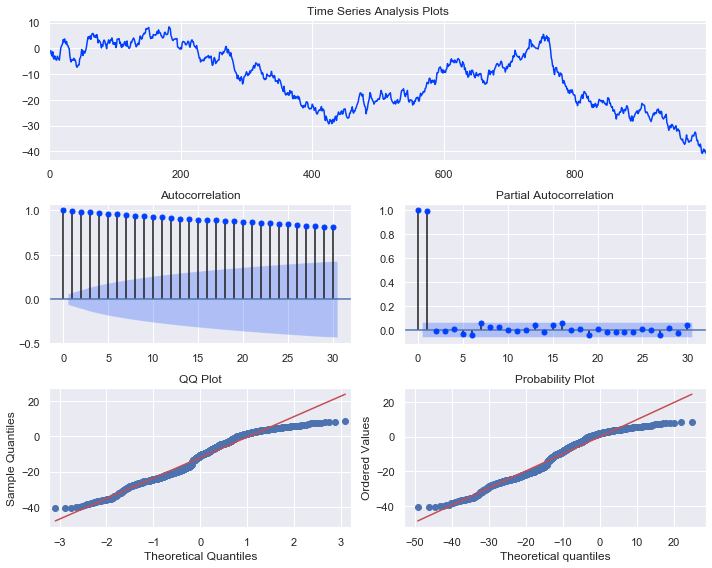

In [3]:
n_sample=1000
np.random.seed(123)
e=np.random.normal(size=n_sample)
x=e.copy()

for t in range(n_sample):
    x[t]=x[t-1]+e[t]

tsplot(x)


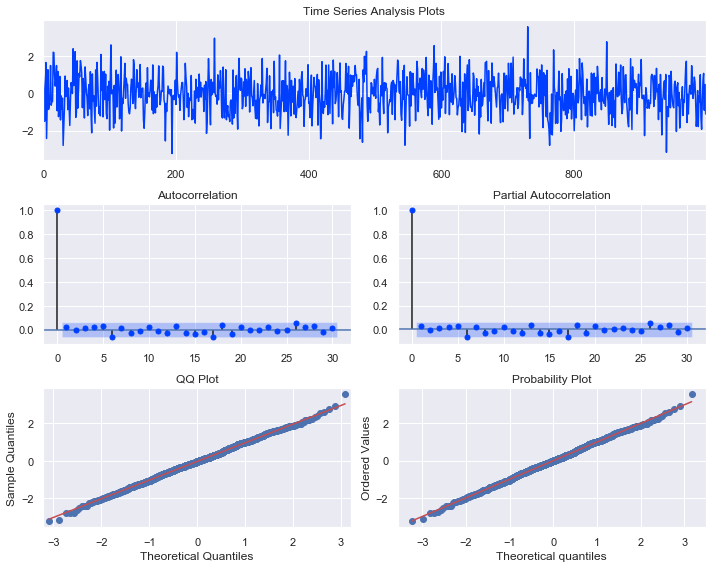

In [4]:
tsplot(np.diff(x))

In [5]:
dftest=adfuller(np.diff(x),autolag="AIC")

In [6]:
dftest

(-30.762707043931066,
 0.0,
 0,
 998,
 {'1%': -3.4369193380671, '5%': -2.864440383452517, '10%': -2.56831430323573},
 2762.883900417585)

Get Stock Data from the web

In [7]:
def Get_Stock_data():
    symbols = ['^NSEI']
    start = datetime.datetime(2018,1,1)
    end = datetime.date.today()
    # Specifically chosen to include the AAPL split on June 9, 2014.
    for symbol in symbols:
        stock_data = web.DataReader(
            symbol,
            'yahoo',
            start,
            end
        )
        '''data.rename(
            columns={
                'Open': 'open',
                'High': 'high',
                'Low': 'low',
                'Close': 'close',
                'Volume': 'volume',
            },
            inplace=True,'''
        
        #del data['Adj Close']

        #dest = join(here, symbol + '.csv')
        #print("Writing %s -> %s" % (symbol, dest))
        #data.to_csv(dest, index_label='day')
        return stock_data

In [8]:
data=Get_Stock_data()

C:\Users\jesvi\Miniconda3\lib\site-packages\pandas_datareader\data.py:387: ResourceWarning: unclosed <socket.socket fd=3808, family=AddressFamily.AF_INET6, type=SocketKind.SOCK_STREAM, proto=0, laddr=('2409:4072:11c:f061:703e:4128:b0fb:99e2', 65221, 0, 0), raddr=('2406:2000:98:800::e5', 443, 0, 0)>
  session=session,


In [9]:
data.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-01-02,10495.200195,10404.650391,10477.549805,10442.200195,153400.0,10442.200195
2018-01-03,10503.599609,10429.549805,10482.650391,10443.200195,167300.0,10443.200195
2018-01-04,10513.000000,10441.450195,10469.400391,10504.799805,174900.0,10504.799805
2018-01-05,10566.099609,10520.099609,10534.250000,10558.849609,180900.0,10558.849609
2018-01-08,10631.200195,10588.549805,10591.700195,10623.599609,169000.0,10623.599609


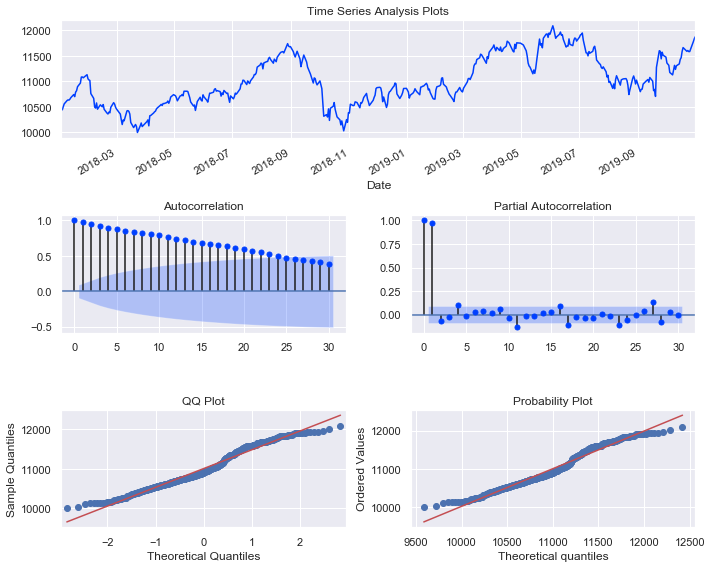

In [10]:
tsplot(data['Adj Close'],lags=30)

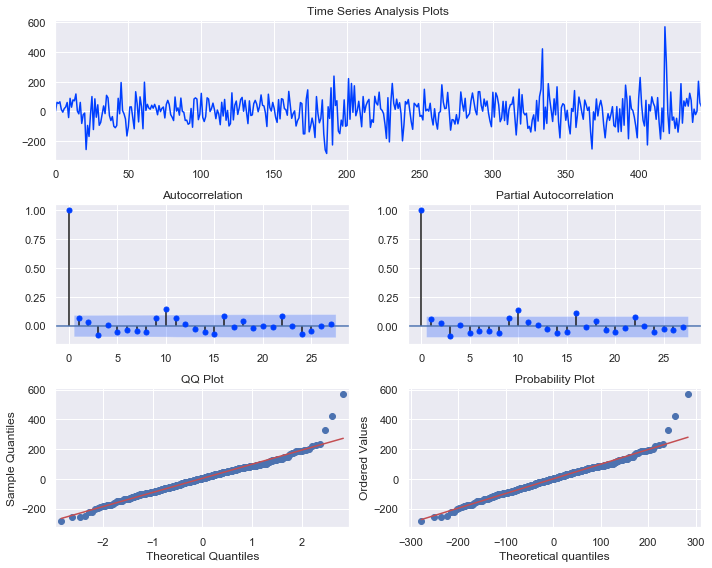

In [11]:
tsplot(np.diff(data['Adj Close']))

In [12]:
adfresult=adfuller(data['Adj Close'],autolag="AIC")
print(adfresult)

(-2.026908969480082, 0.2749004902087, 1, 443, {'1%': -3.4451978474132234, '5%': -2.8680864144212057, '10%': -2.5702569996789792}, 5100.928808142024)


AR PROCESS

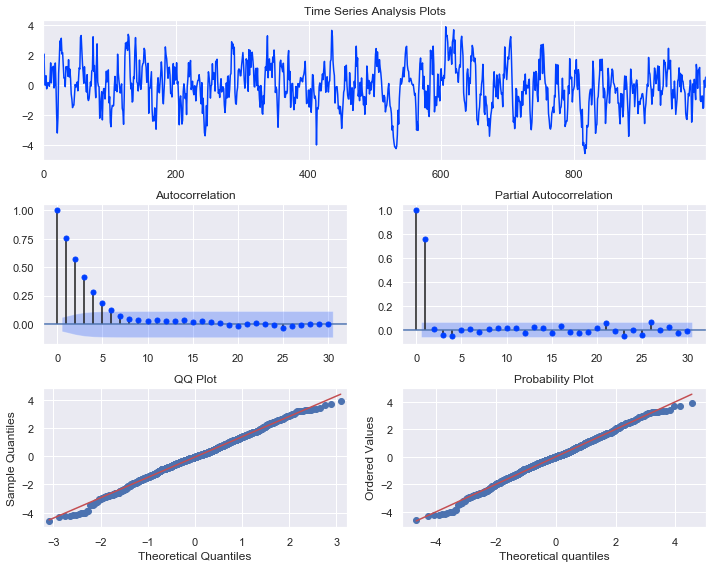

In [13]:
np.random.seed(10)
np_sm=int(1000)
a=0.75

e=np.random.normal(size=np_sm)
x=e.copy()

for t in range(np_sm):
    x[t] = a * x[t-1] + e[t]
tsplot(x,lags=30)

In [14]:
ar_model=sm.tsa.AR(x).fit(maxlag=30,ic='aic',trend='nc')
est_ord=sm.tsa.AR(x).select_order(maxlag=30,ic='aic',trend='nc')


In [15]:
print(ar_model.params,est_ord)

[0.75877722] 1


Simulating and fitting an  𝐴𝑅(3)  process with  𝜙  = [0.4, -0.3, 0.25]

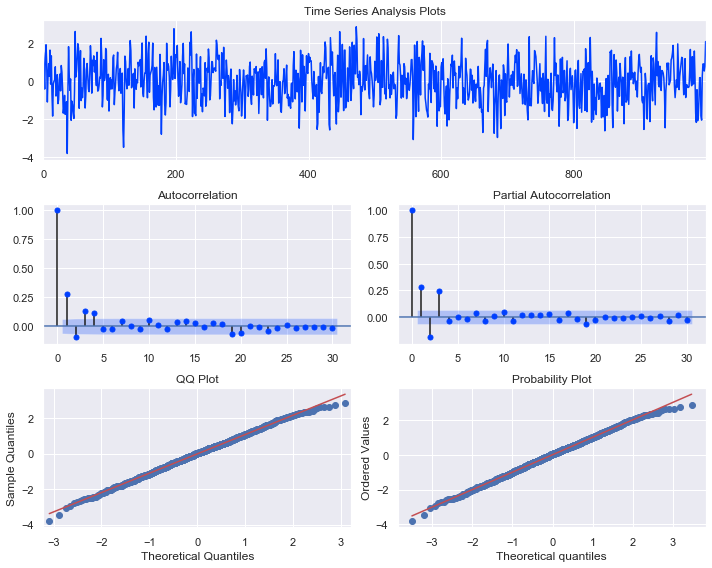

In [16]:
n=int(1000)
a=np.array([0.4, -0.3, 0.25])
t=np.array([0.])

'''ararray_like, 1d
coefficient for autoregressive lag polynomial, including zero lag

maarray_like, 1d
coefficient for moving-average lag polynomial, including zero lag
'''
ar = np.r_[1, -a]
ma = np.r_[1, t]

ar3=sm.tsa.arma_generate_sample(ar=ar,ma=ma,nsample=n)
tsplot(ar3, lags=30)

In [17]:
mdl_ar3=sm.tsa.AR(ar3).fit()#(maxlag=30,ic='aic',trend='nc')
est_order=sm.tsa.AR(ar3).select_order(maxlag=30,ic='aic',trend='nc')
print(len(mdl_ar3.params),est_order)

22 3


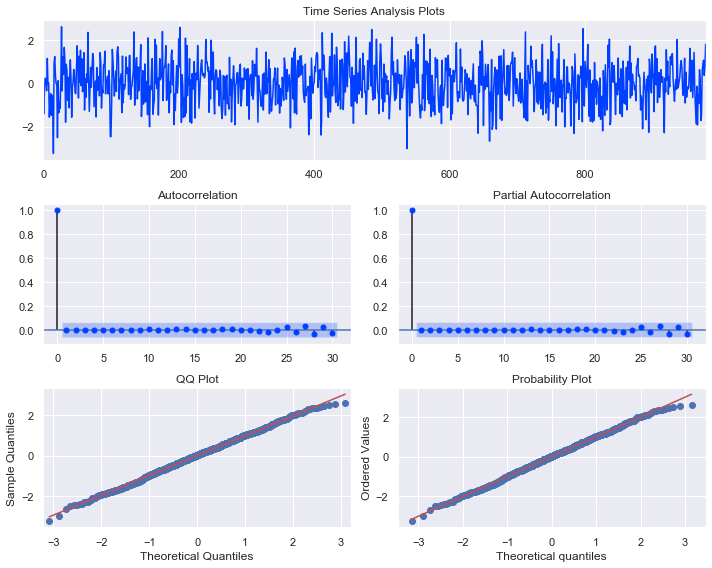

In [18]:
tsplot(mdl_ar3.resid,lags=30)

In [19]:
from statsmodels.stats.stattools import jarque_bera

In [20]:
from statsmodels.stats.stattools import jarque_bera

score, pvalue, _, _ = jarque_bera(mdl_ar3.resid)
if pvalue < 0.05:
    print("Our residuals are likely not normally distributed.")
else:
    print("Our residuals are likely normally distributed.")


Our residuals are likely normally distributed.


MA(1) variable .75

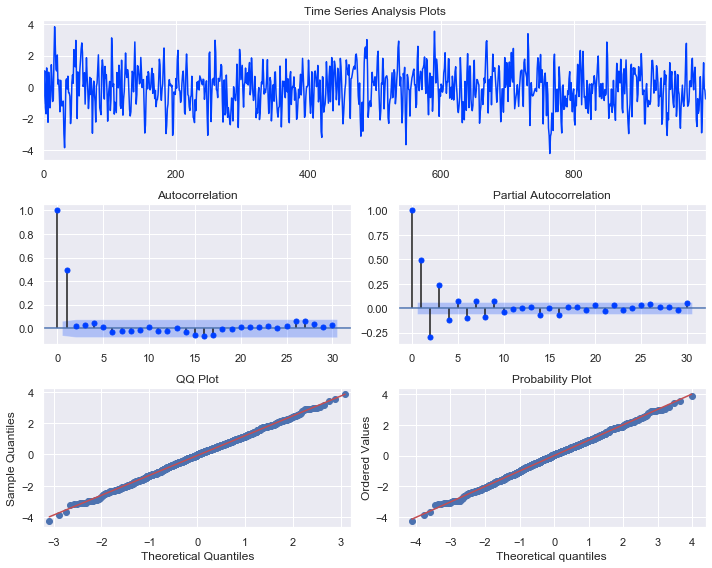

In [26]:
np.random.seed(123)
n=int(1000)

#Generating the arraya

p=np.array([0.])
t=np.array([0.75])

#Adding zero lag and negate P

ar=np.r_[1,-p]
ma=np.r_[1,t]


ma1=smt.arma_generate_sample(ar=ar,ma=ma,nsample=n)
tsplot(ma1,lags=30)
